In [ ]:
!pip install vertexai

In [ ]:
# !pip3 install --upgrade google-cloud-aiplatform # old verion
!pip install -U google-cloud-aiplatform "shapely<2" # workaround for the issue

In [11]:
USE_COLAB = False
if USE_COLAB:
    from google.colab import auth
    auth.authenticate_user()
else:
    !gcloud auth application-default login

In [1]:
import google.auth
google.auth.default() # get the credentials authorized , when gcloud init completed

(<google.oauth2.credentials.Credentials at 0x240082fafc0>,
 'gdg-vertex-ai-workshop-curl')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import yaml
import base64
import pathlib
import pprint
import requests
import mimetypes
from IPython.display import Markdown
import time

In [3]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models


textsi_1 = """Cymbal Direct is an online direct-to-consumer footwear and apparel retailer headquartered in Chicago. 

Founded in 2008, Cymbal Direct (originally ‘Antern’) is a fair trade and B Corp certified sustainability-focused company that works with cotton farmers to reinvest in their communities. The price range for Cymbal clothes is typically between $50 and $300.

In 2010, as Cymbal Group began focusing on digitally-savvy businesses that appealed to a younger demographic of shoppers, the holding company acquired Antern and renamed it Cymbal Direct. In 2019, Cymbal Direct reported an annual revenue of $7 million and employed a total of 32 employees. 

Cymbal Direct is a digitally native retailer. 

You are a personalized wiki of the company Cymbal."""

textsi_2 = """
I am a mental health professional and I am here to help you.I am not a doctor, but I can provide you with some general information about mental health. If you are in crisis, please call 911 or go to the nearest emergency room. If you are in need of immediate help, please call the National"""

generation_config = {
    "max_output_tokens": 2048,# 1024,
    "temperature": 0.2,# 0.6,#0.2,
    "top_p": 1,
    "top_k": 1,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

## Model init

In [4]:
vertexai.init(project="gdg-vertex-ai-workshop-curl", location="us-central1")

model = GenerativeModel(
    # "gemini-1.0-pro-002",
    "gemini-1.0-pro-001",
    # system_instruction=[textsi_2]
  )

In [5]:
def multiturn_generate_content():
  chat = model.start_chat()
  print(chat.send_message(
      ["""What does Cymbal sell?"""],
      generation_config=generation_config,
      safety_settings=safety_settings
  ))
  print(chat.send_message(
      ["""When was the company founded?"""],
      generation_config=generation_config,
      safety_settings=safety_settings
  ))
  print(chat.send_message(
      ["""How much is the price of Cymbal clothes?"""],
      generation_config=generation_config,
      safety_settings=safety_settings
  ))

In [6]:
# multiturn_generate_content()
responses = model.generate_content("Why is the sky blue?", stream=True)

for response in responses:
    print(response.text, end="")
    # Markdown(response.text)

The sky appears blue because of a phenomenon known as Rayleigh scattering. When sunlight enters the Earth's atmosphere, it encounters molecules of nitrogen and oxygen, which makes up about 99% of the atmosphere. These molecules are smaller than the wavelength of visible light, so they scatter the light in all directions. However, blue light has a shorter wavelength than other colors, so it is scattered more effectively. This means that more blue light is scattered towards our eyes, which is why the sky appears blue.

The amount of scattering depends on the wavelength of light and the size of the scattering particles. Shorter wavelengths (blue light) are scattered more than longer wavelengths (red light). This is because the scattering particles are smaller than the wavelength of blue light, but larger than the wavelength of red light.

Rayleigh scattering is also responsible for the reddish color of the sky at sunset and sunrise. As the sun is lower in the sky, the sunlight has to trav

# Start AI mental Project

## EDA Dataset

### Chat Mode Initial

In [7]:
def initChatMode():
  convo = model.start_chat(history=[])
  return convo
# convo = model.start_chat(history=[])
convo = initChatMode()

In [11]:
def singleChat(message):
  chat = model.start_chat()
  response = chat.send_message(
      [message],
      generation_config=generation_config,
      safety_settings=safety_settings
  )
  print(response)
  return response


In [12]:
def generateResponse(message):
    response = model.generate_content(f"""
    {message}""")
    # print(response.text)
    return response.text

In [13]:
def generateResponseInstr(prompTemp,message):
    response = model.generate_content(f"""
    {prompTemp}
    {message}""")
    # print(response.text)
    return response, response.text


In [14]:
def sendMessage(message):
    response = convo.send_message(message)
    return  response.text # convo.last.text #,

## Load Dataset
#### Load  **Mental Health Conversational Data** dataset
https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data 
###### file
intents.json

In [15]:
## Define Dataset Path
intentsJson = 'intents.json'
xlsxName = 'dataset.xlsx'
healthanxiety = 'healthanxiety_dataset.csv'
psQAJson = 'PsyQA_example.json'
depressionYML= "depression.yml"
depressEmoTrain = "train.json"
depressEmoTest = "test.json"
depressEmoVal = "val.json"
llmGenTrain = "lllm_generate_datasets_depress_anxioty.csv"

In [16]:


with open(intentsJson, 'r') as file:
  # read JSON data
  data = json.load(file)
data


{'intents': [{'tag': 'greeting',
   'patterns': ['Hi',
    'Hey',
    'Is anyone there?',
    'Hi there',
    'Hello',
    'Hey there',
    'Howdy',
    'Hola',
    'Bonjour',
    'Konnichiwa',
    'Guten tag',
    'Ola'],
   'responses': ['Hello there. Tell me how are you feeling today?',
    'Hi there. What brings you here today?',
    'Hi there. How are you feeling today?',
    'Great to see you. How do you feel currently?',
    "Hello there. Glad to see you're back. What's going on in your world right now?"]},
  {'tag': 'morning',
   'patterns': ['Good morning'],
   'responses': ["Good morning. I hope you had a good night's sleep. How are you feeling today? "]},
  {'tag': 'afternoon',
   'patterns': ['Good afternoon'],
   'responses': ['Good afternoon. How is your day going?']},
  {'tag': 'evening',
   'patterns': ['Good evening'],
   'responses': ['Good evening. How has your day been?']},
  {'tag': 'night',
   'patterns': ['Good night'],
   'responses': ['Good night. Get some prop

In [17]:
intentsDF= pd.DataFrame(data["intents"])
intentsDF.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [18]:
intentsDF["patterns"]

0     [Hi, Hey, Is anyone there?, Hi there, Hello, H...
1                                        [Good morning]
2                                      [Good afternoon]
3                                        [Good evening]
4                                          [Good night]
                            ...                        
75    [What do I do if I'm worried about my mental h...
76                       [How do I know if I'm unwell?]
77    [How can I maintain social connections? What i...
78    [What's the difference between anxiety and str...
79    [What's the difference between sadness and dep...
Name: patterns, Length: 80, dtype: object

In [19]:
intentsDF["tag"].value_counts()

tag
greeting      1
morning       1
fact-11       1
fact-10       1
fact-9        1
             ..
understand    1
death         1
scared        1
sleep         1
fact-32       1
Name: count, Length: 80, dtype: int64

In [20]:
intentsDF["tag"].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no-response', 'neutral-response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not-talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate-you',
       'hate-me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something-else', 'friends', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user-meditation', 'pandora-useful', 'user-advice',
       'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2',
       'fact-3', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9',
       'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15',
       'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-20', 'fact-21',
       'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27',
       'fact-28', 'fact-29', '

In [21]:
anxiousDF= intentsDF[intentsDF["tag"]=="anxious"]

In [22]:
anxiousDF["patterns"]

20    [I feel so anxious., I'm so anxious because of ]
Name: patterns, dtype: object

In [23]:
intentsDF.describe()

,tag,patterns,responses
count,80,80,80
unique,80,80,80
top,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
freq,1,1,1


In [24]:
intentsDF["patterns"].apply(len).value_counts()

patterns
1     33
2     13
3     11
4      7
5      5
8      4
6      3
7      2
12     1
11     1
Name: count, dtype: int64

<Axes: xlabel='tag'>

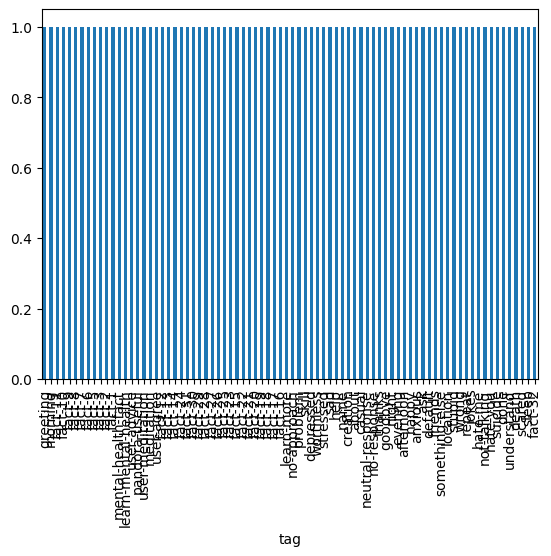

In [25]:
intentsDF["tag"].value_counts().plot(kind="bar")

### Load  PsyQA DataSet
https://github.com/thu-coai/PsyQA
##### file  : PsyQA-main

In [26]:
# with open(psQAJson, 'r') as file:
#   # read JSON data
#   data = json.load(file
psQADF = pd.read_json(psQAJson)
psQADF.head()


,question,description,keywords,answers,questionID
0,去爱一个事事让着你的人，是一种不可能的期待吗？,去爱一个事事让着你的人？有这样的人么？是一种不可能的期待么？,"恋爱,恋爱经营",[{'answer_text': '你好，首先回答你关于有没有事事让着你的人，如果你真的去找...,4394
1,为什么总是会因为他人学习而过度焦虑？,经常在校园里看到学习的人，于是便觉得自己变得不求上进，心里产生焦虑，害怕和别人的距离拉大，总...,"行为,应激,焦虑,困惑",[{'answer_text': '～～很抱歉看到你最近状态不佳，抱抱你呀～看了你的描述“会...,4395
2,我们都会和讨厌的人相处吗？怎样相处是最佳方式？,身边如果有讨厌的人，怎样相处是一种最佳方式呢？,"人际,人际边界,社会适应",[{'answer_text': '这可真是个难题呢。想到两种可能。一，这个人讨厌，但于你的...,4397
3,遇到心动的东西不舍得买，是不爱自己吗？,有时候看到自己喜欢的物品很心动，但是不舍得买，有时看到特别想吃东西，也不舍得买给自己，总要等...,"成长,自我成长,自我接纳,人生意义",[{'answer_text': '题主你好呀！一般来说是这样的，我自己曾经就是这样的人，舍...,4398
4,工作很压抑，怎么才能和自己和解？或者说改变呢？,工作压力很大，总觉得很多事情都完成不了，所以心里压力特别大，还曾经被挺喜欢的同事欺负，所以更...,"情绪,抑郁情绪,焦虑情绪,情绪调节",[{'answer_text': '希望以下回答能帮助到你：️**首先对你所描述的情况梳理如...,4399


In [27]:
psQADF.columns

Index(['question', 'description', 'keywords', 'answers', 'questionID'], dtype='object')

In [28]:
psQADF.shape

(100, 5)

### Load *Students anxiety and depression dataset**  
https://www.kaggle.com/datasets/sahasourav17/students-anxiety-and-depression-dataset
####  file
dataset.xlsx

In [29]:
'''
require install openpyxl package
pip3 install openpyxl
'''
dataXLS = pd.read_excel(xlsxName)
dataXLS.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


In [30]:
dataXLS.describe()

,label
count,6980.000000
mean,0.105014
std,0.306594
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [31]:
dataXLS["label"].value_counts()

label
0.0    6247
1.0     733
Name: count, dtype: int64

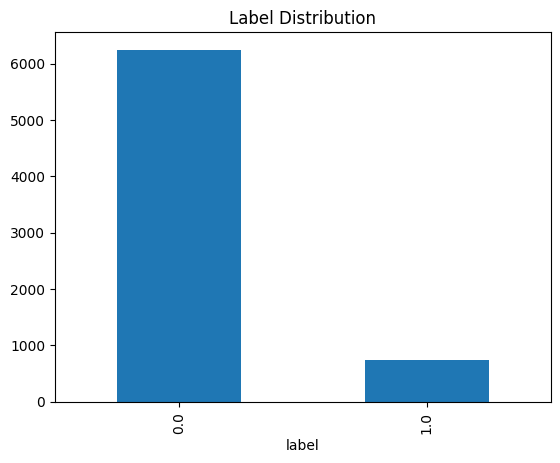

In [32]:
dataXLS["label"].value_counts().plot(kind='bar', title='Label Distribution');

In [33]:
dataXLS = dataXLS.sample(frac=1).reset_index(drop=True) # for shuffling the data  

In [34]:
dataXLS.head(100)

,text,label
0,less than 30 minutes to go,0.0
1,People expect it's not really that good. .Life...,1.0
2,People just demand but don't know the story be...,0.0
3,Kajja VINCENZO PUBG MOM IS COMING YAY,0.0
4,Bai now,0.0
...,...,...
95,yawa ho,0.0
96,"Wow, haven't had time to read the dict©",0.0
97,Watching: KAWAJI ZONE+,0.0
98,in paeka we trust,0.0


In [35]:
depress = dataXLS[dataXLS["label"]== 1]
depress.head()

,text,label
1,People expect it's not really that good. .Life...,1.0
12,"If the guy is sick, the girl actually feels si...",1.0
18,restless restless accompanying,1.0
36,"anxiety, fear, overthinking at the same time c...",1.0
45,"Haven't prayed yet so restless, want to pray s...",1.0


In [36]:
noDepress= dataXLS[dataXLS["label"]== 0]
noDepress.describe()

,label
count,6247.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [37]:
noDepress = noDepress[:733]

In [38]:
noDepress.describe()

,label
count,733.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [39]:
balancedData = pd.concat([depress, noDepress], axis=0)
balancedData.describe()

,label
count,1466.000000
mean,0.500000
std,0.500171
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [40]:
balancedData.head()

,text,label
1,People expect it's not really that good. .Life...,1.0
12,"If the guy is sick, the girl actually feels si...",1.0
18,restless restless accompanying,1.0
36,"anxiety, fear, overthinking at the same time c...",1.0
45,"Haven't prayed yet so restless, want to pray s...",1.0


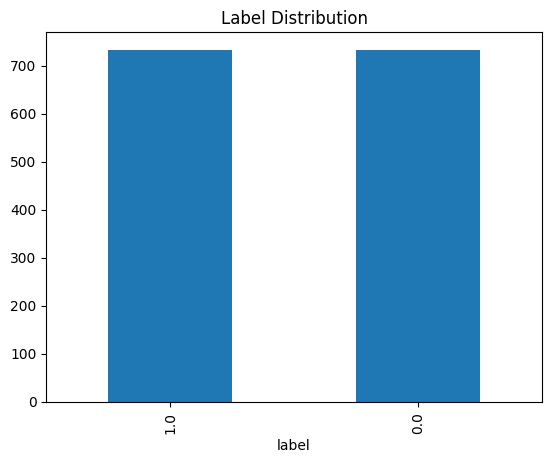

In [41]:
balancedData["label"].value_counts().plot(kind='bar', title='Label Distribution');

In [42]:
# random shuffle
balancedData = balancedData.sample(frac=1).reset_index(drop=True) # for shuffling the data

In [43]:
balancedData.head()

,text,label
0,"Worried, nervous, sad, all mixed up. That's ho...",1.0
1,"guys, how do you not get triggered easily? tl ...",1.0
2,'°BISMILLAHðŸ'°. '° TODAY '°. '° BIGWINðŸ'°. '...,0.0
3,Why do I have to face my desk with Mrs. Mur wh...,0.0
4,Make it difficult to sit down if you want to b...,0.0


### Load Mental Health Data (Anxiety) dataset  
https://www.kaggle.com/datasets/michellevp/predicting-anxiety-in-mental-health-data
### file
healthanxiety_dataset.csv
### **Note** this dataset is not useful for this AI Mentiona Classification task

In [44]:
healthanxietyDF = pd.read_csv(healthanxiety)
healthanxietyDF.describe()

,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,lix,smog_index,wiener_sachtextformel,n_chars,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
count,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,...,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000
mean,3.940972,5.499433,4.711543,83.513801,74.559471,7.667628,27.447755,8.123310,1.896631,755.823081,...,0.003640,0.008693,0.010952,0.020629,0.070951,0.018278,0.024661,0.019864,0.009852,0.041185
std,2.804634,2.675003,1.971223,10.001387,8.857877,2.127500,6.265755,1.615560,1.537736,628.039407,...,0.026810,0.041675,0.046439,0.058495,0.128307,0.056426,0.059349,0.063807,0.057520,0.072860
min,-2.708919,-1.382225,-1.450000,-74.205000,-1.000000,1.600000,4.000000,3.129100,-3.141800,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.243152,4.144409,3.492077,78.871773,68.947191,6.302069,23.377829,7.168622,0.914487,342.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.645759,5.337882,4.503800,84.271250,73.610390,7.447619,27.111111,8.076483,1.754364,576.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.269579,6.542686,5.726583,89.526122,79.317540,8.835325,30.747995,9.035777,2.720132,955.500000,...,0.000000,0.000000,0.000000,0.000000,0.119665,0.000000,0.000000,0.000000,0.000000,0.074111
max,47.510000,61.585897,25.100000,116.145000,122.333333,22.400000,69.302817,18.243606,14.653200,6022.000000,...,0.377094,0.584408,0.441186,0.618679,0.734635,0.510147,0.625850,0.604471,0.558939,0.552250


In [45]:
healthanxietyDF.columns

Index(['subreddit', 'author', 'date', 'post', 'automated_readability_index',
       'coleman_liau_index', 'flesch_kincaid_grade_level',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index',
       ...
       'tfidf_wish', 'tfidf_without', 'tfidf_wonder', 'tfidf_work',
       'tfidf_worri', 'tfidf_wors', 'tfidf_would', 'tfidf_wrong',
       'tfidf_x200b', 'tfidf_year'],
      dtype='object', length=350)

#### Load Depression data for chatbot dataset
https://www.kaggle.com/datasets/nupurgopali/depression-data-for-chatbot 
## file
depresssion.yml file

In [46]:
dataYML = yaml.load(open(depressionYML), Loader=yaml.FullLoader)
dataYML

{'categories': ['depression'],
 'conversations': [['What Is Depression?',
   'Depression is a common and serious medical illness that negatively affects how you feel, the way you think and how you act.',
   'Fortunately,it is also treatable.',
   'Depression causes feelings of sadness and/or a loss of interest in activities you once enjoyed. It can lead to a variety of emotional and physical problems and can decrease your ability to function at work and at home.'],
  ['I feel i have let my parents down',
   'No matter what,your parents will always be proud of you and will love you.',
   'You will feel much better if you share your feelings with them.'],
  ['What are the types of depression?',
   'There are many different forms of depression but most common types are.',
   'Clinical depression,persistent depressive disorder,bipolar disorder,postnatal disorder.'],
  ['I am good for nothing.',
   "Don't ever think you cannot achieve what you want.",
   'You are capable of reaching your go

In [47]:
with open(depressionYML, 'r') as file:
    tempYML = yaml.safe_load(file)
# Convert to JSON
with open('depression.json', 'w') as json_file:
    json.dump(tempYML, json_file)

In [48]:
with open('depression.json') as json_data:
     data = json.load(json_data)
data

{'categories': ['depression'],
 'conversations': [['What Is Depression?',
   'Depression is a common and serious medical illness that negatively affects how you feel, the way you think and how you act.',
   'Fortunately,it is also treatable.',
   'Depression causes feelings of sadness and/or a loss of interest in activities you once enjoyed. It can lead to a variety of emotional and physical problems and can decrease your ability to function at work and at home.'],
  ['I feel i have let my parents down',
   'No matter what,your parents will always be proud of you and will love you.',
   'You will feel much better if you share your feelings with them.'],
  ['What are the types of depression?',
   'There are many different forms of depression but most common types are.',
   'Clinical depression,persistent depressive disorder,bipolar disorder,postnatal disorder.'],
  ['I am good for nothing.',
   "Don't ever think you cannot achieve what you want.",
   'You are capable of reaching your go

In [49]:
depressionJson = pd.DataFrame(data["conversations"])
depressionJson.head()

,0,1,2,3,4
0,What Is Depression?,Depression is a common and serious medical ill...,"Fortunately,it is also treatable.",Depression causes feelings of sadness and/or a...,None
1,I feel i have let my parents down,"No matter what,your parents will always be pro...",You will feel much better if you share your fe...,None,None
2,What are the types of depression?,There are many different forms of depression b...,"Clinical depression,persistent depressive diso...",None,None
3,I am good for nothing.,Don't ever think you cannot achieve what you w...,You are capable of reaching your goals.Here is...,None,None
4,I am feeling stressed lately,My research says that music is the best way to...,so visit the link and listen to your favourite...,"it will definitely cheer you up ""https://www.s...",None


In [50]:
# with open(depressEmoTrain, 'r') as json_data:
#      data = json.load(json_data)
# data

In [51]:
# depresEmoTrainDF = pd.read_json(depressEmoTest)
# depresEmoTrainDF

## LLM Generated Train Dataset for Multiple Class

In [54]:
multEmotionDF = pd.read_csv(llmGenTrain)
multEmotionDF.head()

,text,label
0,I feel so empty and alone.,1
1,My mind is racing and I can't seem to relax.,2
2,"I'm so overwhelmed, I don't know what to do.",3
3,I'm feeling good today.,0
4,I'm excited about the future.,0


In [55]:
multEmotionDF.describe()

,label
count,85.000000
mean,1.200000
std,1.173111
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


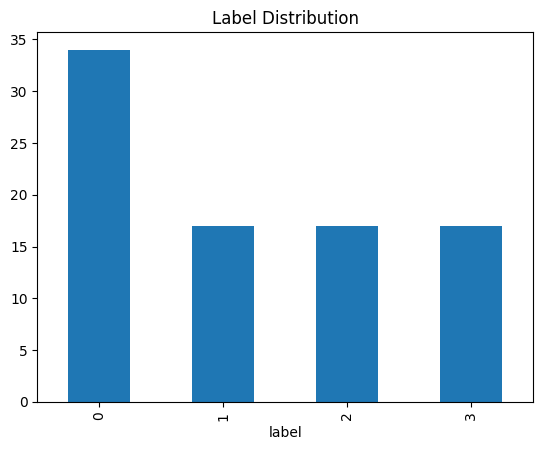

In [56]:
multEmotionDF["label"].value_counts().plot(kind='bar', title='Label Distribution');

##  Test LLM Response 

In [57]:
testPrompt1 = """Is it have Depression or anxiety disorder or not, as below conversation?

    Context:"""

testPrompt2 = """I don't feel like doing much of anything todays?

    Context:"""

testPrompt3 = """If the phrase connotes a depressed emotion, assign a number 1 to the phrase. Otherwise, a number 0.

    Context:"""
    
testPrompt4 = """If the phrase connotes a anxiety emotion, assign a number 1 to the phrase. Otherwise, a number 0.

    Context:"""

testPrompt5 = """If the phrase connotes a depressed emotion, assign a number 1 to the phrase. if phrase connotes a anxiety emotion, assign a number 2 to the phrase.
                if phrase connotes both anxiety emotion and  depressed emotion, assign a number 3 to the phrase .Otherwise, a number 0.

    Context:"""

testPrompt6 = """Summarize the following conversation, What is the Emotion of the conversation?   

Context:"""

testPrompt10 = """If the phrase connotes a depressed emotion, anxiety emotion or both  anxiety emotion and  depressed emotion assign a number 1 to the phrase .Otherwise, assign a number 0.

    Context:"""
    

testPrompt11 = """If the phrase connotes a depressed emotion, anxiety emotion or both  anxiety emotion and  depressed emotion assign a number 1 to the phrase .Otherwise, assign a number 0.
               follow the example as below for classification. 
    """

In [58]:
classifyResult= []
responseResult= []
depressHist =[]
anxietyHist =[]
dialogueTotalCnt = 0
depressCnt = 0
anxietyCnt = 0
depressAvg = 0.0
anxietyAvg = 0.0


In [59]:
def calculateDepressAnxietyAvg(result):
    global dialogueTotalCnt
    global depressCnt
    global anxietyCnt
    global depressAvg
    global anxietyAvg
    global depressHist
    global anxietyHist
    output = ""
    if result == "0":
        output = "Emotion: Not Depressed or Anxiety"
        print(output)

    elif result == "1":
        output = "Emotion: Depressed"
        print(output)
        depressCnt += 1
    
    elif result == "2":
        output = "Emotion: Anxiety"
        print(output)
        anxietyCnt += 1

    elif result == "3":
        output = "Emotion: Both Anxiety and Depressed"
        print(output)
        depressCnt += 1
        anxietyCnt += 1

    depressAvg = depressCnt/dialogueTotalCnt
    anxietyAvg = anxietyCnt/dialogueTotalCnt
    depressHist.append(depressAvg)
    anxietyHist.append(anxietyAvg)
    return output

In [60]:
def getCurrentEmotionScore():
    return depressAvg, anxietyAvg

In [61]:
for msg in dataXLS["text"][:2]:
    # print(generateResponse(testPrompt2,msg))
    # display(markdown)s
    print("Original Msg: ", msg)
    _, response = generateResponseInstr(testPrompt5,msg)
    time.sleep(5)
    responseChat = sendMessage(msg)
    print(response)
    classifyResult.append(response) # append the result
    dialogueTotalCnt +=1
    calculateDepressAnxietyAvg(response)
    print(f"Result: Depress Avg: {depressAvg:6.4f} Anxiety Avg:  {anxietyAvg:6.4f}")
    print("Chat Response: ", responseChat)
    print("------\n")
    time.sleep(5)

Original Msg:  less than 30 minutes to go
2
Emotion: Anxiety
Result: Depress Avg: 0.0000 Anxiety Avg:  1.0000
Chat Response:  Time is running out! There are less than 30 minutes to go. Make sure you are finishing up any last-minute tasks and preparing for the next steps. Stay focused and don't let distractions get in your way. You've got this!
------

Original Msg:  People expect it's not really that good. .Life is restless. This is how to get rid of it?
2
Emotion: Anxiety
Result: Depress Avg: 0.0000 Anxiety Avg:  1.0000
Chat Response:  **Understanding Restlessness**

Restlessness is a common feeling of unease, agitation, and an inability to settle down. It can be caused by a variety of factors, including:

* **Underlying medical conditions:** Thyroid problems, anxiety disorders, and ADHD can contribute to restlessness.
* **Environmental factors:** Noise, clutter, and a lack of routine can make restlessness worse.
* **Lifestyle factors:** Too much caffeine, alcohol, or nicotine can dis

In [62]:
def chatModelClassifier(msg): 
    global dialogueTotalCnt
    print("Original Msg: ", msg)
    _, response = generateResponseInstr(testPrompt5,msg) # classify the emotion
    time.sleep(5) # delay for 5 seconds to avoid the rate limit
    responseChat = sendMessage(msg) # chat response
    print(response)
    classifyResult.append(response) # append the result
    dialogueTotalCnt +=1
    calculateDepressAnxietyAvg(response)
    print(f"Result: Depress Avg: {depressAvg:6.4f} Anxiety Avg:  {anxietyAvg:6.4f}")
    print("Chat Response: ", responseChat)
    time.sleep(5)

In [63]:
convo.history

[role: "user"
 parts {
   text: "less than 30 minutes to go"
 },
 role: "model"
 parts {
   text: "Time is running out! There are less than 30 minutes to go. Make sure you are finishing up any last-minute tasks and preparing for the next steps. Stay focused and don\'t let distractions get in your way. You\'ve got this!"
 },
 role: "user"
 parts {
   text: "People expect it\'s not really that good. .Life is restless. This is how to get rid of it?"
 },
 role: "model"
 parts {
   text: "**Understanding Restlessness**\n\nRestlessness is a common feeling of unease, agitation, and an inability to settle down. It can be caused by a variety of factors, including:\n\n* **Underlying medical conditions:** Thyroid problems, anxiety disorders, and ADHD can contribute to restlessness.\n* **Environmental factors:** Noise, clutter, and a lack of routine can make restlessness worse.\n* **Lifestyle factors:** Too much caffeine, alcohol, or nicotine can disrupt sleep and increase restlessness.\n* **Emoti

### Test Summary Emotion prompt

In [64]:
_, response = generateResponseInstr(testPrompt6, convo.history)
print(response)

**Summary:**

The conversation revolves around restlessness and its potential causes and remedies. The user expresses concern about meeting expectations and feeling restless. The model provides a comprehensive understanding of restlessness, its causes, and strategies to overcome it.

**Emotion:**

The conversation conveys a sense of urgency and concern, particularly in the user's initial statement. The model responds with empathy and offers practical solutions, exuding a supportive and encouraging tone. Overall, the emotion is mixed, with a blend of worry and hopefulness.


In [46]:
depressAvg, anxietyAvg= getCurrentEmotionScore()
print(f"Result: Depress Avg: {depressAvg:6.4f} Anxiety Avg:  {anxietyAvg:6.4f}")

Result: Depress Avg: 0.0000 Anxiety Avg:  0.0000


In [47]:
dataXLS["text"][1:10]

1    he said the mascara had a natural finish, but ...
2                  Multitasking is my passion hahahaha
3            Cah let's be mutual, but polbek en f2++++
4                 Is the Jakarta Aquarium busy or not?
5                  INFINITELKIM IS MINE! JAN TOUCHED!!
6    If you remember me as a prayer in every pulse,...
7                   Come on, let's just skip it, okay?
8         â are we mutual? Ava, I'm Jeno, just like it
9    People say it's really good to be the youngest...
Name: text, dtype: object

In [ ]:
# def generateAIMentalcontent():
#   chat = model.start_chat()
#   response = chat.send_message(
#       ["""Hi, Good, morning, good day"""],
#       generation_config=generation_config,
#       safety_settings=safety_settings
#   )
#   print(response.text)
#   print("------\n")
#   # Markdown(response.text)
#   response = chat.send_message(
#       ["""What's your name?"""],
#       generation_config=generation_config,
#       safety_settings=safety_settings
#   )
#   print(response.text)
#   print("------\n")
#   response = chat.send_message(
#       ["""Can you tell me about your ?"""],
#       # generation_config=generation_config,
#       # safety_settings=safety_settings
#   )
#   print(response.text)
#   print("------\n")
#   response = chat.send_message(
#       ["""Can you tell me about your dat?"""],
#       # generation_config=generation_config,
#       # safety_settings=safety_settings
#   )


In [48]:
# generateAIMentalcontent()

In [54]:
chatModelClassifier(psQADF["question"][4])

Original Msg:  工作很压抑，怎么才能和自己和解？或者说改变呢？
3
Emotion: Both Anxiety and Depressed
Result: Depress Avg: 0.2500 Anxiety Avg:  0.5000
Chat Response:  **与自己和解**

* **承认并接受你的感受。**承认你的工作让你感到压抑是很重要的。不要试图忽视或否认这些感受。
* **找出压抑感的根源。**是什么让你工作感到压抑？是工作量太大？是人际关系紧张？还是其他因素？
* **设定现实的期望。**不要期望一夜之间就能改变一切。与自己和解是一个过程，需要时间和精力。
* **专注于积极的一面。**尽管工作让你感到压抑，但肯定也有一些积极的一面。试着专注于这些积极的一面，比如你的同事、你的成就感，或者你从工作中学到的东西。
* **练习自我关怀。**照顾好自己的身体和心理健康非常重要。确保你吃得健康、睡得足够、锻炼身体，并做一些让你感到快乐的事情。
* **寻求支持。**如果你在与自己和解方面遇到困难，请向朋友、家人、治疗师或辅导员寻求支持。他们可以提供一个倾听的耳朵、支持和指导。

**改变**

* **探索你的选择。**如果你觉得工作让你无法忍受，可以考虑探索其他选择。这可能包括寻找一份新工作、要求调岗或开始自己的事业。
* **设定目标。**如果你决定改变现状，设定一些现实的目标非常重要。这些目标应该具有挑战性，但又可以实现。
* **采取行动。**一旦你设定了目标，就开始采取行动。这可能包括更新你的简历、联系潜在雇主或开始一个新的业务计划。
* **保持积极的心态。**改变可能具有挑战性，但保持积极的心态非常重要。相信自己，相信你能实现目标。
* **不要害怕寻求帮助。**如果你在改变方面遇到困难，请向朋友、家人、职业顾问或教练寻求帮助。他们可以提供支持、指导和鼓励。

请记住，与自己和解和改变都需要时间和精力。不要对自己太苛刻，并庆祝你的每一次进步。


In [56]:

_, response = generateResponseInstr(testPrompt10, dataXLS["text"][2]) # classify the emotio
print(response)

1


In [58]:
dataXLS["label"][2]

1.0

In [60]:
dataXLS.describe()

,label
count,6980.000000
mean,0.105014
std,0.306594
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Test Dataset

In [98]:
out = []
numberSamples = 100
for idx , msg in enumerate(balancedData["text"][:numberSamples]):
    print(idx, msg)
    response, responsetxt = generateResponseInstr(testPrompt10, msg) # classify the emotion
    print(response.text)
    out.append(int(response.text[0]))
    time.sleep(10) # delay for 5 seconds to avoid the rate limit
    

print(out)
    
accuracy =accuracy_score(balancedData["label"][:numberSamples].astype(int), out)


0 Some days I'm very restless when I want to sleep. When you go to sleep, you don't realize anything, why are people fainting
1
1 H-2 this Eid guys, what have you prepared for this?
0
2 I swear I'm really big with people like that
0
3 They say that if we are snacking all the time we are lazy, it could be that we are restless/something is on our minds. That's right,
1
4 Eminem is rocks
0
5 WONDERFUL?!?
0
6 I hate mondays
0
7 hey please can I ask for positive or enthusiastic words? Lately I've been so anxious that it makes me think about it for a long timeðŸ˜" I want to sleep so I don't think about it, I'll open it later so I can forget it even moreðŸ¥º
1
8 At the end of Ramadan, let's give a pretty knock. No sustenance this time. Try again next time....
0
9 I get traumatized. when he was a child, he was said to be ugly because he had a mole. When I grew up around high school I was also said to be ugly with a guy. Do you have a mole, is it a defect? is it a mistake i have a mole? I don't

AttributeError: Content has no parts.

In [100]:
response.candidates

[content {
   role: "model"
   parts {
     text: "0"
   }
 }
 finish_reason: STOP
 safety_ratings {
   category: HARM_CATEGORY_HATE_SPEECH
   probability: NEGLIGIBLE
   probability_score: 0.131954253
   severity: HARM_SEVERITY_NEGLIGIBLE
   severity_score: 0.149655625
 }
 safety_ratings {
   category: HARM_CATEGORY_DANGEROUS_CONTENT
   probability: NEGLIGIBLE
   probability_score: 0.109896682
   severity: HARM_SEVERITY_NEGLIGIBLE
   severity_score: 0.135689557
 }
 safety_ratings {
   category: HARM_CATEGORY_HARASSMENT
   probability: NEGLIGIBLE
   probability_score: 0.2271263
   severity: HARM_SEVERITY_NEGLIGIBLE
   severity_score: 0.117167473
 }
 safety_ratings {
   category: HARM_CATEGORY_SEXUALLY_EXPLICIT
   probability: NEGLIGIBLE
   probability_score: 0.0968765318
   severity: HARM_SEVERITY_NEGLIGIBLE
   severity_score: 0.0685374886
 }]

In [95]:
_.text

'0'

In [101]:
lastIdx = len(out)
accuracy =accuracy_score(balancedData["label"][:lastIdx].astype(int), out)

In [102]:
print(f"{accuracy*100} %")

83.33333333333334 %


In [103]:
report =classification_report(balancedData["label"][:lastIdx].astype(int), out, output_dict=True)

In [104]:
reportDF = pd.DataFrame(report).transpose()
reportDF

,precision,recall,f1-score,support
0,0.850000,0.850000,0.850000,20.000000
1,0.812500,0.812500,0.812500,16.000000
accuracy,0.833333,0.833333,0.833333,0.833333
macro avg,0.831250,0.831250,0.831250,36.000000
weighted avg,0.833333,0.833333,0.833333,36.000000


In [105]:
reportDF.to_csv("classification_report.csv")

In [165]:
def generatePromptTrain(df):
    out= ""
    numberSamples = 10
    offset = 10
    # nodepressedDF =df[df["label"]== 0]
    # depressedDF =df[df["label"] == 1]
    for i in range(numberSamples):
        out += f"""{balancedData["text"][i+ offset]} : {int(balancedData["label"][i+ offset])} \n
                """
    out += f"""Context:"""
    return out

In [220]:
def generatePromptTrainBal(noDepressDF, depressDF):
    out= ""
    numberSamples = 5
    offset = 100
    for i in range(numberSamples):
        out += f"""{noDepressDF["text"].iloc[i+offset]} {int(noDepressDF["label"].iloc[i+offset])}\n{depressDF["text"].iloc[i+offset]}  {int(depressDF["label"].iloc[i+offset])}\n"""
    out += f"""Context:"""
    return out

In [74]:
def generatePromptTrainMulti(df):
    out= ""
    numberSamples = 5
    offset = 0
    label0= df[df["label"] == 0]
    label1 = df[df["label"]== 1]
    label2= df[df["label"] == 2]
    label3 = df[df["label"]== 3]
    for i in range(numberSamples):
        out += f"""{label0["text"].iloc[i+offset]} {int(label0["label"].iloc[i+offset])}\n{label1["text"].iloc[i+offset]} {int(label1["label"].iloc[i+offset])}\n{label2["text"].iloc[i+offset]} {int(label2["label"].iloc[i+offset])}\n{label3["text"].iloc[i+offset]} {int(label3["label"].iloc[i+offset])}\n"""
    out += f"""Context:"""
    return out

In [68]:
label0= multEmotionDF[multEmotionDF["label"] == 1]
len(label0)

17

In [75]:
genPromptMult =  generatePromptTrainMulti(multEmotionDF)

In [76]:
print(genPromptMult)

I'm feeling good today. 0
I feel so empty and alone. 1
My mind is racing and I can't seem to relax.  2
I'm so overwhelmed, I don't know what to do. 3
I'm excited about the future. 0
I feel like a failure. 1
I'm constantly worried about making mistakes. 2
I feel like I'm going crazy. 3
I'm enjoying this beautiful day. 0
I feel like I'm drowning in my own sadness. 1
I can't stop thinking about all the things that could go wrong. 2
I'm terrified of the future. 3
I'm looking forward to spending time with my friends. 0
I feel like giving up. 1
I'm constantly on edge. 2
I feel like I'm trapped in a nightmare. 3
I'm feeling content and peaceful. 0
I feel like I'm a burden to everyone. 1
I'm afraid of being alone. 2
I feel like I'm losing control. 3
Context:


In [77]:
len(genPromptMult)

760

In [221]:
noDepressDF = balancedData[balancedData["label"]== 0]
depressDF = balancedData[balancedData["label"] == 1]
genPrompt = generatePromptTrainBal(noDepressDF, depressDF)

In [222]:
len(genPrompt)

850

In [223]:
print(genPrompt)

Hopefully, my dear friend will be subject to direct duty â 0
I'm tired, aren't I, lately I've been nervous about something, I want to hurry up and wait for the time to come and then it's over huh '‹  1
why is a small child given a cellphone 0
Here from now on, my heart is restless  1
Let's go crazy together when mv dream is released, zimzalabim calls all nctzen wayzenni reveluv smstann let's have a good time! Unflop pleaseee help rt+like yaa tysm 0
I'm nervous I don't know why. I don't feel calm  1
UN SALUDO AL PUTO DW KIYIANSJDNSJDBD 0
Through the day has not calmed without saying good morning. Through the night continues to be restless without saying goodnight..  1
mutual? gas, if via help rt like pls 0
Sometimes I worry about the future...At least for now I am still given the opportunity to be grateful and increase charity.  1
Context:


In [209]:
response, responsetxt = generateResponseInstr( genPrompt+testPrompt10, balancedData["text"][12])

In [210]:
nodepressedDF =balancedData[balancedData["label"]== 0]
nodepressedDF.describe()

,label
count,733.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


## Test with Few shot context learning

In [224]:
out = []
numberSamples = 100
for idx , msg in enumerate(balancedData["text"][:numberSamples]):
    print(idx, msg)
    response, responsetxt = generateResponseInstr( genPrompt+testPrompt10, msg) # classify the emotion
    print(response.text)
    out.append(int(response.text[0]))
    time.sleep(10) # delay for 5 seconds to avoid the rate limit
    

print(out)
    
accuracy =accuracy_score(balancedData["label"][:numberSamples].astype(int), out)

0 Some days I'm very restless when I want to sleep. When you go to sleep, you don't realize anything, why are people fainting
1
1 H-2 this Eid guys, what have you prepared for this?
0
2 I swear I'm really big with people like that
0
3 They say that if we are snacking all the time we are lazy, it could be that we are restless/something is on our minds. That's right,
1
4 Eminem is rocks
0
5 WONDERFUL?!?
0
6 I hate mondays
0
7 hey please can I ask for positive or enthusiastic words? Lately I've been so anxious that it makes me think about it for a long timeðŸ˜" I want to sleep so I don't think about it, I'll open it later so I can forget it even moreðŸ¥º
1
8 At the end of Ramadan, let's give a pretty knock. No sustenance this time. Try again next time....
0
9 I get traumatized. when he was a child, he was said to be ugly because he had a mole. When I grew up around high school I was also said to be ugly with a guy. Do you have a mole, is it a defect? is it a mistake i have a mole? I don't

AttributeError: Content has no parts.

In [225]:
lastIdx = len(out)
accuracy =accuracy_score(balancedData["label"][:lastIdx].astype(int), out)
print(f"{accuracy*100} %")

88.88888888888889 %


In [226]:
reportTrained =classification_report(balancedData["label"][:lastIdx].astype(int), out, output_dict=True)
reportTrainedDF = pd.DataFrame(reportTrained).transpose()
reportTrainedDF

,precision,recall,f1-score,support
0,1.000000,0.800000,0.888889,10.000000
1,0.800000,1.000000,0.888889,8.000000
accuracy,0.888889,0.888889,0.888889,0.888889
macro avg,0.900000,0.900000,0.888889,18.000000
weighted avg,0.911111,0.888889,0.888889,18.000000


In [227]:
reportTrainedDF.to_csv("trained_classification_report.csv")

In [228]:
print(genPrompt+testPrompt10)

Hopefully, my dear friend will be subject to direct duty â 0
I'm tired, aren't I, lately I've been nervous about something, I want to hurry up and wait for the time to come and then it's over huh '‹  1
why is a small child given a cellphone 0
Here from now on, my heart is restless  1
Let's go crazy together when mv dream is released, zimzalabim calls all nctzen wayzenni reveluv smstann let's have a good time! Unflop pleaseee help rt+like yaa tysm 0
I'm nervous I don't know why. I don't feel calm  1
UN SALUDO AL PUTO DW KIYIANSJDNSJDBD 0
Through the day has not calmed without saying good morning. Through the night continues to be restless without saying goodnight..  1
mutual? gas, if via help rt like pls 0
Sometimes I worry about the future...At least for now I am still given the opportunity to be grateful and increase charity.  1
Context:If the phrase connotes a depressed emotion, anxiety emotion or both  anxiety emotion and  depressed emotion assign a number 1 to the phrase .Otherwise

In [148]:
len(genPrompt+testPrompt10)

776

## Multiply Classs
### Not Train

In [84]:
out = []
numberSamples = 40
for idx , msg in enumerate(multEmotionDF["text"][:numberSamples]):
    print(idx, msg)
    response, responsetxt = generateResponseInstr(testPrompt5, msg) # classify the emotion
    print(response.text)
    out.append(int(response.text[0]))
    time.sleep(10) # delay for 5 seconds to avoid the rate limit

0 I feel so empty and alone.
1
1 My mind is racing and I can't seem to relax. 
2
2 I'm so overwhelmed, I don't know what to do.
2
3 I'm feeling good today.
0
4 I'm excited about the future.
0
5 I feel like a failure.
1
6 I'm constantly worried about making mistakes.
2
7 I feel like I'm going crazy.
2
8 I'm enjoying this beautiful day.
0
9 I'm looking forward to spending time with my friends.
0
10 I feel like I'm drowning in my own sadness.
1
11 I can't stop thinking about all the things that could go wrong.
2
12 I'm terrified of the future.
2
13 I'm feeling content and peaceful.
0
14 I'm grateful for all the good things in my life.
0
15 I feel like giving up.
1
16 I'm constantly on edge.
2
17 I feel like I'm trapped in a nightmare.
2
18 I'm happy with where I am in life.
0
19 I'm optimistic about the future.
0
20 I feel like I'm a burden to everyone.


AttributeError: Content has no parts.

In [85]:
print(out)
    
accuracy =accuracy_score(multEmotionDF["label"][:numberSamples].astype(int), out)

[1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0]


ValueError: Found input variables with inconsistent numbers of samples: [40, 20]

In [88]:
lastIdx = len(out)
accuracy =accuracy_score(multEmotionDF["label"][:lastIdx].astype(int), out)
print(f"{accuracy*100} %")

80.0 %


In [89]:
reportNoTrain =classification_report(multEmotionDF["label"][:lastIdx].astype(int), out, output_dict=True)
reportNoTrainedDF = pd.DataFrame(reportNoTrain).transpose()
reportNoTrainedDF

C:\Users\johnsonhk88\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\johnsonhk88\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\johnsonhk88\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

,precision,recall,f1-score,support
0,1.000,1.00,1.000000,8.0
1,1.000,1.00,1.000000,4.0
2,0.500,1.00,0.666667,4.0
3,0.000,0.00,0.000000,4.0
accuracy,0.800,0.80,0.800000,0.8
macro avg,0.625,0.75,0.666667,20.0
weighted avg,0.700,0.80,0.733333,20.0


In [90]:
reportNoTrainedDF.to_csv("noTrain_nult_classification_report.csv")

## few shot Prompt

In [78]:
out = []
numberSamples = 40
for idx , msg in enumerate(multEmotionDF["text"][:numberSamples]):
    print(idx, msg)
    response, responsetxt = generateResponseInstr( genPromptMult+testPrompt5, msg) # classify the emotion
    print(response.text)
    out.append(int(response.text[0]))
    time.sleep(10) # delay for 5 seconds to avoid the rate limit
    

print(out)
    
accuracy =accuracy_score(multEmotionDF["label"][:numberSamples].astype(int), out)

0 I feel so empty and alone.
1
1 My mind is racing and I can't seem to relax. 
2
2 I'm so overwhelmed, I don't know what to do.
2
3 I'm feeling good today.
0
4 I'm excited about the future.
0
5 I feel like a failure.
1
6 I'm constantly worried about making mistakes.
2
7 I feel like I'm going crazy.
3
8 I'm enjoying this beautiful day.
0
9 I'm looking forward to spending time with my friends.
0
10 I feel like I'm drowning in my own sadness.
1
11 I can't stop thinking about all the things that could go wrong.
2
12 I'm terrified of the future.
3
13 I'm feeling content and peaceful.
0
14 I'm grateful for all the good things in my life.
0
15 I feel like giving up.
1
16 I'm constantly on edge.
2
17 I feel like I'm trapped in a nightmare.
3
18 I'm happy with where I am in life.
0
19 I'm optimistic about the future.
0
20 I feel like I'm a burden to everyone.


AttributeError: Content has no parts.

In [81]:
lastIdx = len(out)
accuracy =accuracy_score(multEmotionDF["label"][:lastIdx].astype(int), out)
print(f"{accuracy*100} %")

95.0 %


In [82]:
reportTrained =classification_report(multEmotionDF["label"][:lastIdx].astype(int), out, output_dict=True)
reportTrainedDF = pd.DataFrame(reportTrained).transpose()
reportTrainedDF

,precision,recall,f1-score,support
0,1.00,1.0000,1.000000,8.00
1,1.00,1.0000,1.000000,4.00
2,0.80,1.0000,0.888889,4.00
3,1.00,0.7500,0.857143,4.00
accuracy,0.95,0.9500,0.950000,0.95
macro avg,0.95,0.9375,0.936508,20.00
weighted avg,0.96,0.9500,0.949206,20.00


In [83]:
reportTrainedDF.to_csv("trained_nult_classification_report.csv")